# 8.3 Adjoint Differentiation Through Non-Linear System of Equations

### Example Non-Linear System
Imagine we have a non-linear system of equations $g(p, x) = 0$:
$$
\begin{align*}
g_1(p, x) &= (p_1 - p_2) x_1^2 - x_2 = 0 \\
g_2(p, x) &= \ln(x_2) + 1 - p_3 x_1 = 0 
\end{align*}
$$

The jacobian(s) of $g$ are:
$$g_p = \begin{bmatrix} x_1^2 & - x_1^2 & 0 \\ 0 & 0 & -x_1 \end{bmatrix}$$

and: $$g_x = \begin{bmatrix} 2 (p_1 - p_2) x_1 & -1 \\ -p_3 & \frac{1}{x2} \end{bmatrix}$$

Let's assume that $p_1 - p_2 = 1 = p_3$.
From $g_1$ we can easily infer that $x_2=x_1^2 \implies 2 \ln(x_1) +1 = x_1$

In [1]:
import torch

def g1(p, x): return (p[0] - p[1]) * x[0]**2 - x[1]

def g2(p, x): return torch.log(x[1]) + 1 - p[2] * x[0]

def g(p, x): return torch.stack([g1(p, x), g2(p, x)])

In [2]:
%%capture
import matplotlib.pyplot as plt
xs = torch.linspace(0.5, 5 , 100)
t = torch.tensor
p0 = t([1., 0., 1.])
plt.plot(xs, xs)
plt.plot(xs, 2 * torch.log(xs) + 1)

If $p=[1, 0, 1]$, then the solutions for $x_1$ are close to 0.6 and close to 3.5. The solution for $x_2 = x_1^2$

In [3]:
s1 = t([1., 1.])
s2 = t([3.5, 3.5**2])
g(p=p0, x=s1), g(p=p0, x=s2)

(tensor([0., 0.]), tensor([0.0000, 0.0055]))

# Implicit Function Theorem

We are interested changing $p$ (and therefore $x$) to optimize a function $f(x(p))$ while still respecting $g(p, x) = 0$.
$$
\begin{align*}
dg &= \frac{\partial g}{\partial p} dp + \frac{\partial g}{\partial x} dx = 0 \\
&= g_p dp + g_x dx \\
\implies dx &= - g_x^{-1} g_p dp & \text{(I)}
\end{align*}
$$
Note that $dg$ has size $|g|$, so $g_p dp$ should have the same size.

This also tells us how to compute $\nabla x$:
$$
\begin{align*}
dx 
&= x'(p) dp \\
&= \underbrace{- g_x^{-1} g_p}_{h} \ dp & \text{(from I)} \\
\implies \nabla_p x &= h
\end{align*}
$$
Meaning $h$ is the result of solving the linear system with matrix $\frac{\partial g}{\partial x}$ and vector $- \frac{\partial g}{\partial p}$.

Writing down $df$:
$$
\begin{align*}
df &= f'(x) dx \\
&= - f'(x)g_x^{-1} g_p dp \\
&= \underbrace{- f_x g_x^{-1}}_{v^T} g_p dp \\ 
\implies \nabla_p f &= v^T g_p
\end{align*}
$$

This means that $v$ is the result of solving the linear system with matrix $(\partial g / \partial x )^T$ (Jacobian transposed) and the vector $-f'(x)$.

$$
\begin{align*}
df &= f_x dx + f_p dp \\
&= f_x dx - f_p g_p^{-1} g_x dx \\
&= (f_x - \underbrace{f_p g_p^{-1}}_{z^T} g_x) dx \\
\implies \nabla_x f &= f_x - z^T g_x
\end{align*}
$$
Where $z$ results from solving a linear system with matrix $g_p^T$ and vector $f_p$ (which is always 0).

Imagine we want to minimize $f(x(p)) = || x ||_2$

From the previous notebook we know that $f'(x) = \frac{x}{f(x)}$

# Solve system Using Scipy

In [4]:
from scipy.optimize import root
from torch import Tensor

jac = torch.autograd.functional.jacobian

def find_x(p: Tensor, x_guess: Tensor):
    def f(x):
        return g_np(p.numpy(), x)

    def _jac_x(x):
        return jacobians(p, t(x))[1].numpy()

    solution = root(f, x0=x_guess.numpy(), jac=_jac_x, method="lm")
    # print(solution.message)
    
    return t(solution.x, dtype=torch.float32)

def g_np(p, x): return g(t(p), t(x)).numpy()

def jacobians(p, x):
    dgdp, dgdx = jac(g, (p, x))
    return dgdp, dgdx

assert 2 == len(jacobians(p0, s1))

In [5]:
print(find_x(p=p0, x_guess=s2))
g(p0, find_x(p=p0, x_guess=s2))

tensor([ 3.5129, 12.3402])


tensor([0., 0.])

# Optimize With PyTorch

In [6]:
from torch import norm
from torch.linalg import solve, lstsq

def f(x): return norm(x)

def fprime(x): return x / f(x)

def grads(p, x):
    dgdp, dgdx = jacobians(p, x)
    fp = fprime(x)
    z = lstsq(dgdp.T, torch.zeros_like(p)).solution
    v = solve(dgdx.T, - fp)
    grad_x = fp - z @ dgdx
    grad_p = v.T @ dgdp
    return grad_p, grad_x

In [7]:
jacobians(p0, s2)

(tensor([[ 12.2500, -12.2500,   0.0000],
         [  0.0000,   0.0000,  -3.5000]]),
 tensor([[ 7.0000, -1.0000],
         [-1.0000,  0.0816]]))

In [8]:
grad_p, grad_x = grads(p0, s2)
grad_p, grad_x

/var/folders/l0/hp0gs2xs7890bxf3bycjt0400000gn/T/ipykernel_4727/1623098011.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  grad_p = v.T @ dgdp


(tensor([ 28.1246, -28.1246, -57.2107]), tensor([0.2747, 0.9615]))

In [9]:
def g_violation(x): return norm(g(p, x))

In [10]:
torch.random.manual_seed(5)

p = p0 + torch.randn_like(p0)
x = find_x(p=p, x_guess=s2)

violations = []
ps = []
xs = []
grads_x = []
grads_p = []
for _ in range(100):
    ps.append(p)
    xs.append(x)
    violations.append(g_violation(x))
    grad_p, grad_x = grads(p=p, x=x)
    grads_x.append(grad_x)
    grads_p.append(grad_p)
    p = p - grad_p
    x = find_x(p=p, x_guess=x)

xs = torch.stack(xs)
grads_x = torch.stack(grads_x)
grads_p = torch.stack(grads_p)

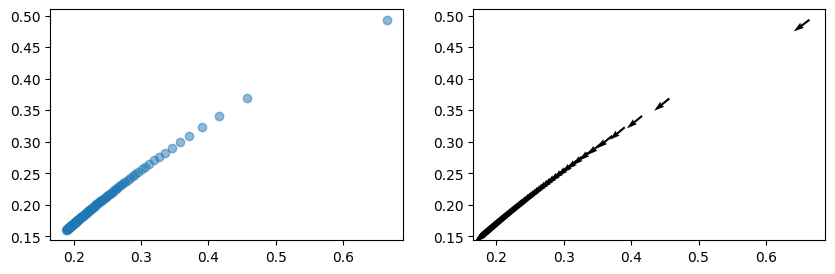

In [11]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axs[0].scatter(xs[:, 0], xs[:, 1], alpha=.5)
axs[1].quiver(xs[:,0], xs[:,1], -grads_x[:,0], -grads_x[:,1])

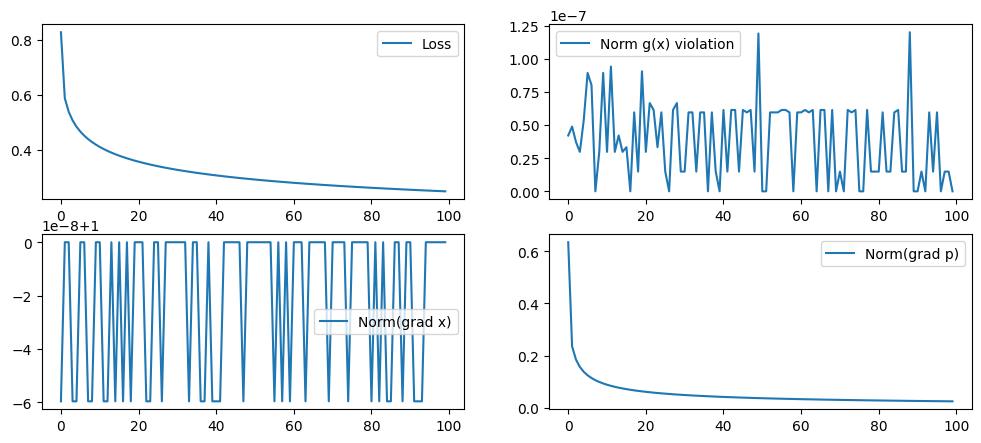

In [12]:
fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
axs[1][0].plot(norm(grads_x, dim=1), label="Norm(grad x)")
axs[1][0].legend()
axs[1][1].plot(norm(grads_p, dim=1), label="Norm(grad p)")
axs[1][1].legend()
axs[0][0].plot([f(x) for x in xs], label="Loss")
axs[0][0].legend()
axs[0][1].plot(violations, label="Norm g(x) violation")
axs[0][1].legend()
plt.show()

# Takeaway

We solve the non-linear system using a non-differentiable Scipy procedure. Nevertheless we can differentiate through it by using the Implicit Function theorem to take derivatives, and plug them into our optimization procedure. The same derivatives can be plugged in in and automatic differentiation (AD) framework, like Pytorch.